# Multiple Regression Practice with the Boston House Dataset

## Contents

### 1. [Dataset Description](#s1)
### 2. [Exploratory Data Analysis](#EDA)
### 3. [Predictive Modeling](#PM)  

  - 3.1 [Linear Regression](#s31)
  - 3.2 [Ridge Regression](#s32)
  - 3.3 [Lasso Regression](#s33)
  - 3.4 [Decision Tree Regressor](#s34)
  - 3.5 [Random Forest Regressor](#s35)
  - 3.6 [XGBoost Regressor](#s36)
  - 3.7 [Linear Support Vector Regressor](#s37)  

### 4. [Model Evaluation](#s4)

----

<a id='s1'></a>
# 1. Dataset Description

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
from sklearn import datasets
boston = datasets.load_boston()
type(boston)

sklearn.utils.Bunch

The `boston` object works like a dictionary in that we can use the `keys` function.

In [4]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [5]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [6]:
boston.feature_names 

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [7]:
boston.data.shape

(506, 13)

In [8]:
boston_df  = pd.DataFrame(boston['data']) 
boston_df.columns = boston['feature_names'] # Set column indeces as feature names
boston_df['PRICE'] = boston.target # Specify MEDV (PRICE) as the target variable.
boston_df.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2

----

<a id='EDA'></a>
## 2. Exploratory Data Analysis

Text(0, 0.5, 'Number of Houses')

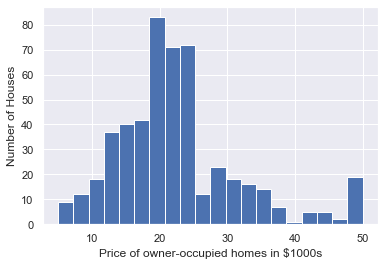

In [9]:
plt.hist(boston_df['PRICE'], bins=20)
plt.xlabel('Price of owner-occupied homes in $1000s')
plt.ylabel('Number of Houses')

To check if there are any missing values in the data, use the `isnull()` method.

In [10]:
def check_null_values(df):
    n_col = len(df.columns)
    null_counts = np.array(df.isnull().sum())
    if np.any(null_counts) == False:
        print("The DataFrame has no null values.")
    else:
        return df.isnull().sum()
        
check_null_values(boston_df)

The DataFrame has no null values.


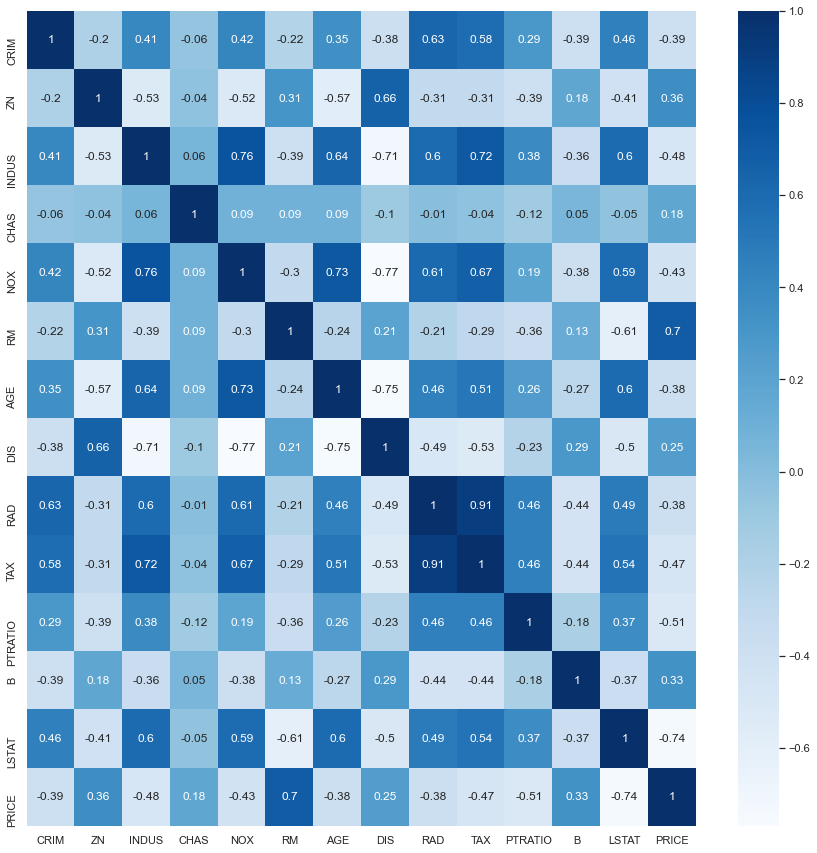

In [11]:
# Plotting the correlation between the features
corr = boston_df.corr().round(2)
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, cmap='Blues')

From this plot, we can see that `RM` and `LSTAT` are very strongly correlated with `PRICE`. It may be helpful to use these features for my model.

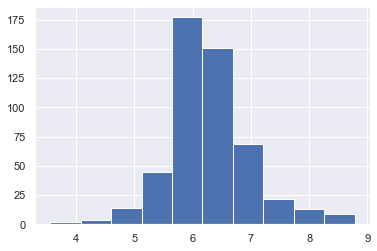

In [12]:
boston_df.RM.hist()

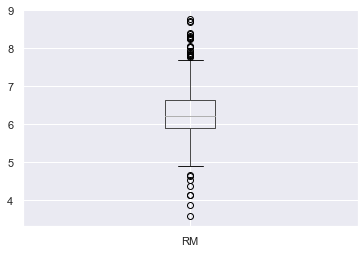

In [13]:
boston_df.boxplot(column = 'RM')

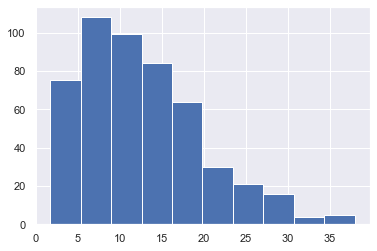

In [14]:
boston_df.LSTAT.hist()

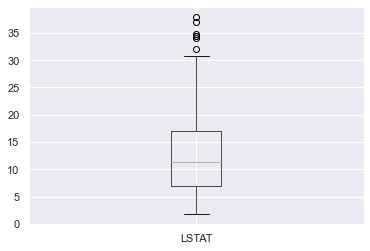

In [15]:
boston_df.boxplot(column = 'LSTAT')

In [16]:
# boston_df.values is the array version of the dataframe
X = boston_df.values[: , :-1]
y = boston_df.values[: , -1].reshape(len(X[:,0]), 1)
X.shape, y.shape

((506, 13), (506, 1))

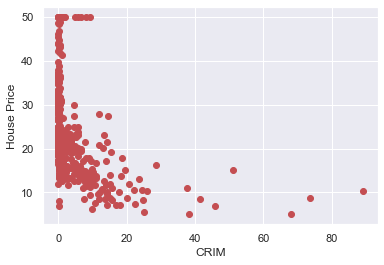

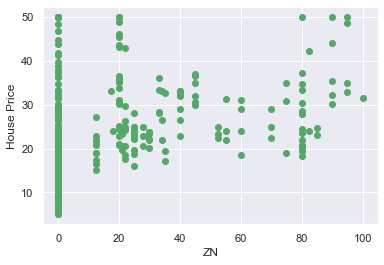

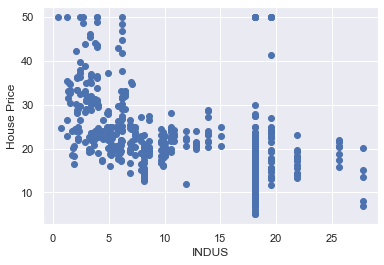

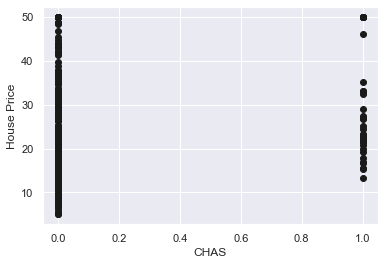

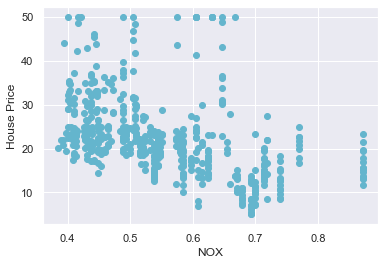

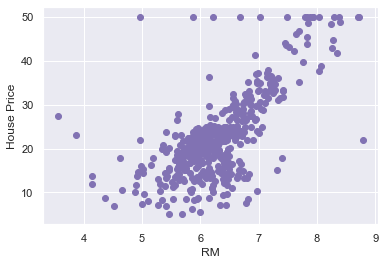

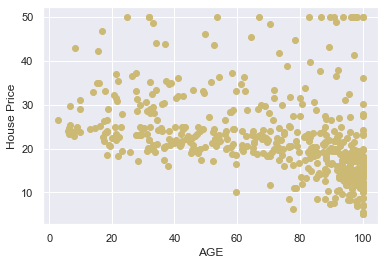

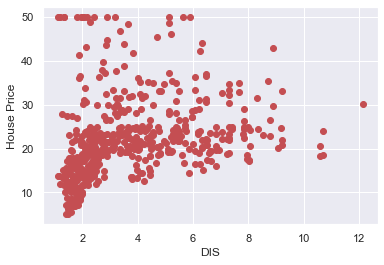

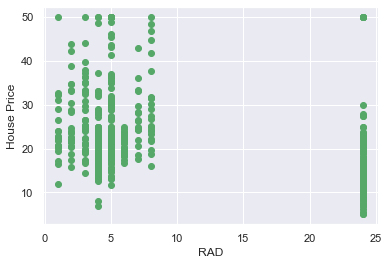

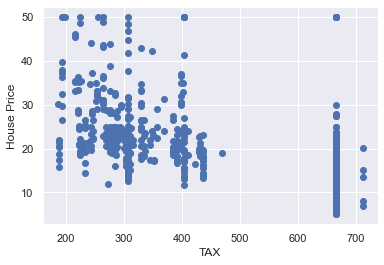

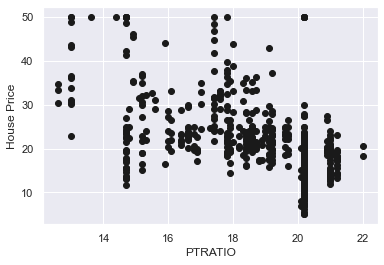

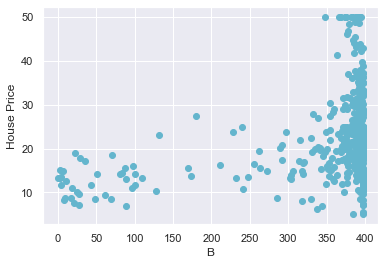

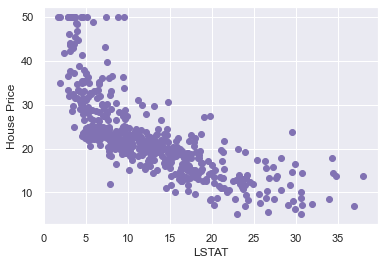

In [17]:
n_features = len(X[0])
colors = ['r', 'g', 'b', 'k', 'c', 'm', 'y']
color_wheel = colors + colors
for i in np.arange(n_features):
    x = X[:, i]
    plt.figure()
    plt.xlabel(boston.feature_names[i])
    plt.ylabel('House Price')
    plt.plot(x, y, str(color_wheel[i])+'o' )
    plt.show()

----

<a id='PM'></a>
# 3. Predictive Modeling


In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=7)

<a id='s31'></a>
## 3.1 Linear Regression Model

Model/Approximation:
$$ y = X\beta + \epsilon. $$
$y$ (array of shape (n_samples, 1)):  the targets or predicted values, <br>
$X$ (array of shape (n_samples, n_features + 1)): the design matrix, <br>
$\beta$ (array of shape (n_features + 1, 1)): coefficient matrix, <br>
$\epsilon$ (array of shape (n_samples, 1)): the residual (or error).

Let $p$ denote the number of features, `n_features`, and $n$ denote the number of samples, `n_samples`. Then,
$$ 
y = X\beta + \epsilon \equiv 
\begin{pmatrix} 
    y_1 \\ \vdots \\ y_n
\end{pmatrix} = 
\begin{pmatrix}
    1 & x_{11} & \cdots & x_{1p} \\
    1 & x_{21} & \cdots & x_{2p} \\
    \vdots & \vdots & \ddots & \vdots \\
    1 & x_{n1} & \cdots & x_{np}
\end{pmatrix}
\begin{pmatrix}
    \beta_0 \\ \beta_1 \\ \vdots \\ \beta_p
\end{pmatrix} + 
\begin{pmatrix}
    \epsilon_1 \\ \vdots \\ \epsilon_n
\end{pmatrix}
$$

Notice, $\epsilon = y-X\beta$, which is why $(y-X\beta)^2 \equiv (y-\hat{y})^2$ is called a square residual.

In [19]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(X_train, Y_train) # trains the model, i.e. finds the β coefficients 

LinearRegression()

``` 
intercept_ : float or array of shape (n_targets,)  
    Independent term in the linear model. Set to 0.0 if
    `fit_intercept = False`. 
```
In mathematical terms, the intercept is defined as the mean or expectation of $y$ when all of the features in the model are set to zero, so it's $\beta_0$ in the matrix formalism above. 

#### Mini Proof: 
If $X_i$ denotes the $i$th column of $X$, then
$$
\mathbb{E}(y) = \mathbb{E}(X\beta + \epsilon) = \mathbb{E}(X\beta) = \mathbb{E}\left(\beta_0 + \sum\limits_{i=1}^p \beta_i X_i \right). 
$$
And when each feature value, $\beta_i$, is set equal to 0, $\mathbb{E}(y) = \beta_0$.


In [20]:
# Return the independent term, or intercept, of the linear model
print('β_0 : ', LR.intercept_)

β_0 :  [23.56213673]


In [21]:
LR.singular_

array([3.26946107e+03, 1.43575338e+03, 5.36008812e+02, 3.07647869e+02,
       1.17360510e+02, 9.76095363e+01, 7.28379831e+01, 5.80252113e+01,
       3.34777752e+01, 2.06076526e+01, 9.40959779e+00, 4.77312471e+00,
       1.01441301e+00])

In [22]:
# Return an array of the regression coefficients
LR.coef_

array([[-1.05682313e-01,  2.78511721e-02,  1.97751387e-02,
         2.74948915e+00, -1.55671652e+01,  5.31495793e+00,
        -1.07626811e-02, -1.31230457e+00,  2.55970709e-01,
        -1.06786333e-02, -9.61979065e-01,  1.18877016e-02,
        -3.85699081e-01]])

Mean absolute error (MAE):
$$ \text{MAE} = \frac{1}{n} \sum\limits_{i=1}^n |\hat{y}_i - y_i |$$

Mean squared error (MSE):
$$\text{MSE} = \frac{1}{n} \sum\limits_{i=1}^n (\hat{y}_i - y_i)^2 $$

root mean square error/deviation (RMSE/RMSD):
$$ \text{RMSE}(\hat{y}) = \sqrt{\text{MSE}(\hat{y})} = \sqrt{ \frac{1}{n} \sum\limits_{i=1}^n (\hat{y}_i - y_i)^2 }$$ 

$R^2$ Score:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

https://en.wikipedia.org/wiki/Coefficient_of_determination


In [41]:
from sklearn import metrics

def model_train(Sklearn_model, X_train=X_train, Y_train=Y_train):
    """Trains a scikit-learn model

    Args:
        Sklearn_model ([type]): [description]
        X_train ([type], optional): [description]. Defaults to X_train.
        Y_train ([type], optional): [description]. Defaults to Y_train.

    Returns:
        model : [description]
    """
    model = Sklearn_model
    model.fit(X_train, Y_train) # trains model, i.e. finds parameters
    return model

def model_metrics(model, X_train=X_train, X_test=X_test, Y_test=Y_test):
    Y_pred = model.predict(X_test) # an array of predicted values
    MAE = metrics.mean_absolute_error(Y_test, Y_pred)
    MSE = metrics.mean_squared_error(Y_test, Y_pred)
    RMSE = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))
    R2 = metrics.r2_score(Y_test, Y_pred)
    metric_values = np.array([MAE, MSE, RMSE, R2])
    return metric_values, Y_pred

def print_metrics(metric_values):
    print("MAE", metric_values[0])
    print("MSE", metric_values[1])
    print("RMSE", metric_values[2])
    print("R-squared Score:", metric_values[3])
    
def graph_vs_predictions(Y_pred, Y_test=Y_test):
    plt.scatter(Y_test, Y_pred)
    plt.xlabel("Prices: $Y_i$")
    plt.ylabel("Predicted prices: $\hat{Y}_i$")
    plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

MAE 3.307638451069791
MSE 25.767879490836645
RMSE 5.076207195420282
R-squared Score: 0.6508417720329545


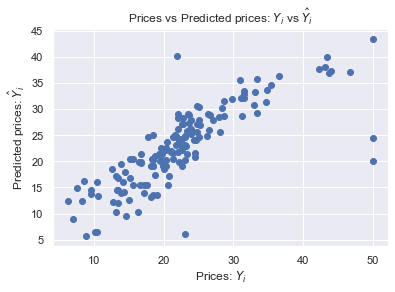

In [42]:
reg_0 = LR

metric_values = model_metrics(model_train(reg_0))[0] 
Y_pred = model_metrics(model_train(reg_0))[1]

print_metrics(metric_values)
graph_vs_predictions(Y_pred)

<a id='s32'></a>
## 3.2 Ridge Regression

[Wikipedia Summary](https://en.wikipedia.org/wiki/Tikhonov_regularization)
> Tikhonov regularization, named for Andrey Tikhonov, is a method of regularization of ill-posed problems. Also known as ridge regression, it is particularly useful to mitigate the problem of multicollinearity in linear regression, which commonly occurs in models with large numbers of parameters. In general, the method provides improved efficiency in parameter estimation problems in exchange for a tolerable amount of bias (see bias–variance tradeoff).


MAE 3.3150472344063284
MSE 26.27787009427617
RMSE 5.1261945041401
R-squared Score: 0.643931330859861


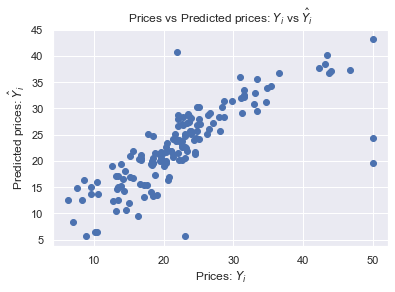

In [71]:
from sklearn.linear_model import Ridge
reg_1 = Ridge()

metric_values = model_metrics(model_train(reg_1))[0] 
Y_pred = model_metrics(model_train(reg_1))[1]

print_metrics(metric_values)
graph_vs_predictions(Y_pred)

<a id='s33'></a>
## 3.3 LASSO Regression

[Wikipedia Summary](https://en.wikipedia.org/wiki/Lasso_(statistics)):
> In statistics and machine learning, lasso (least absolute shrinkage and selection operator; also Lasso or LASSO) is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces.

MAE 3.3416852489576727
MSE 23.90558828559172
RMSE 4.889334135195888
R-squared Score: 0.6760760679870769


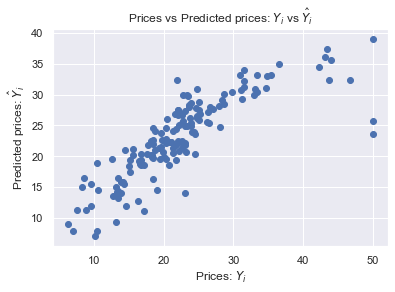

In [72]:
from sklearn.linear_model import Lasso
reg_2 = Lasso()

metric_values = model_metrics(model_train(reg_2))[0] 
Y_pred = model_metrics(model_train(reg_2))[1]

print_metrics(metric_values)
graph_vs_predictions(Y_pred)

<a id='s34'></a>
## 3.4 Decision Tree Regressor

MAE 3.2815789473684216
MSE 25.880263157894735
RMSE 5.087264801235998
R-squared Score: 0.6493189582501442


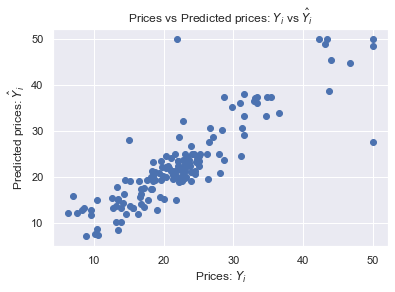

In [73]:
from sklearn.tree import DecisionTreeRegressor
reg_3 = DecisionTreeRegressor()

metric_values = model_metrics(model_train(reg_3))[0] 
Y_pred = model_metrics(model_train(reg_3))[1]

print_metrics(metric_values)
graph_vs_predictions(Y_pred)

<a id='s35'></a>
## 3.5 Random Forest Regressor

C:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


MAE 2.338269736842104
MSE 12.650229927631575
RMSE 3.556716171924824
R-squared Score: 0.8285876854368929


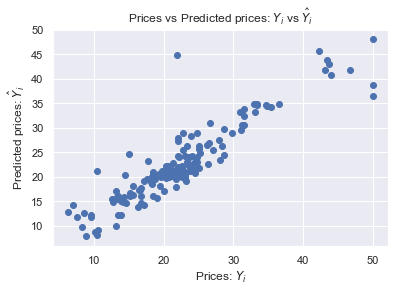

In [74]:
from sklearn.ensemble import RandomForestRegressor
reg_4 = RandomForestRegressor(random_state=3)

metric_values = model_metrics(model_train(reg_4))[0] 
Y_pred = model_metrics(model_train(reg_4))[1]

print_metrics(metric_values)
graph_vs_predictions(Y_pred)

<a id='s36'></a>
## 3.6 XGBoost Regressor 

XGBoost is short for e**X**treme **G**radient **B**oosting.

The author of the algorithm is [Tianqi Chen](https://tqchen.com/). A description of some of the strengths of XGBoost were explained by him in a [quora post](https://www.quora.com/What-is-the-difference-between-the-R-gbm-gradient-boosting-machine-and-xgboost-extreme-gradient-boosting).
> Both xgboost and gbm follows the principle of gradient boosting.  There are however, the difference in modeling details. Specifically,  xgboost used a more regularized model formalization to control over-fitting, which gives it better performance.

> The name xgboost, though, actually refers to the engineering goal to push the limit of computations resources for boosted tree algorithms. Which is the reason why many people use xgboost. 


MAE 2.184927732066104
MSE 12.381583921473455
RMSE 3.518747493281303
R-squared Score: 0.8322278749019961


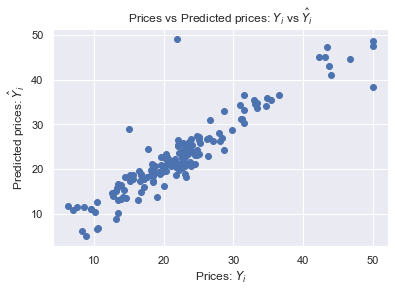

In [75]:
from xgboost import XGBRegressor
reg_5 = XGBRegressor()

metric_values = model_metrics(model_train(reg_5))[0] 
Y_pred = model_metrics(model_train(reg_5))[1]

print_metrics(metric_values)
graph_vs_predictions(Y_pred)

In [ ]:
XGBRegressor?

<a id='s37'></a>
## 3.7 Linear Support Vector Regressor

C:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MAE 3.282386852144568
MSE 31.58808740378112
RMSE 5.620328051260097
R-squared Score: 0.5719771731044268


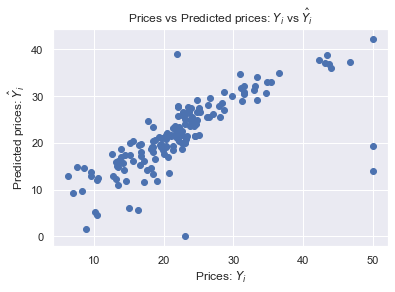

In [76]:
# import SVM Regressor
from sklearn import svm
reg_6 = svm.SVR(kernel='linear')

metric_values = model_metrics(model_train(reg_6))[0] 
Y_pred = model_metrics(model_train(reg_6))[1]

print_metrics(metric_values)
graph_vs_predictions(Y_pred)

---- 

<a id='s4'></a>
# 4. Model Evaluation

# TODO
